In [1]:
import numpy as np
import math
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
df=pd.read_excel('/Users/basilibrahim/Downloads/SMM265 Coursework /cw2024AP.xlsx', index_col=0)

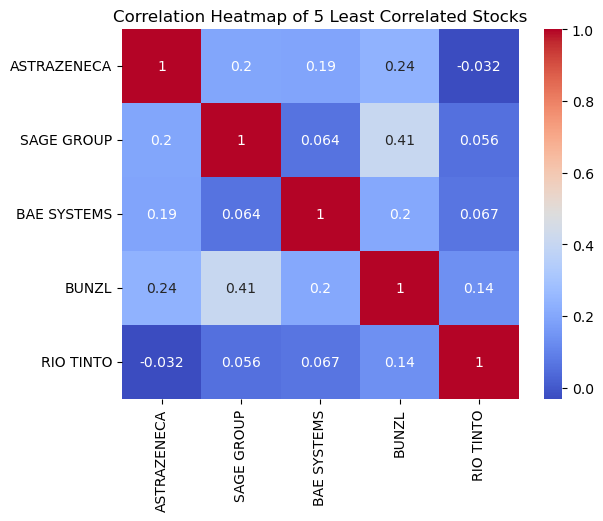

In [3]:
data = df.loc['2014-09-01':'2024-10-31']
risk_free_rate = data['UK GVT BMK BID YLD 1M - RED. YIELD']/12
ftse_index = data['FTSE ALL SHARE - PRICE INDEX']
stocks = data.columns[:-2]

log_returns = np.log(data[stocks] / data[stocks].shift(1))
excess_returns = log_returns.sub(risk_free_rate.iloc[1:len(log_returns) + 1], axis=0)

mean_excess_returns = excess_returns.mean()
std_excess_returns = excess_returns.std()
sharpe_ratios = (mean_excess_returns *12) / (std_excess_returns * np.sqrt(12))
top_10_stocks = sharpe_ratios.nlargest(10)

top_10_stock_names = top_10_stocks.index
top_10_data = log_returns[top_10_stock_names]
correlation_matrix = top_10_data.corr()
correlation_sums = (correlation_matrix.abs().sum() - 1) / sharpe_ratios
least_correlated_stocks = correlation_sums.sort_values().index[:5]
least_correlated_data = top_10_data[least_correlated_stocks]
sns.heatmap(least_correlated_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of 5 Least Correlated Stocks")
plt.show()

In [4]:
data = df.loc['2009-09-01':'2024-10-31']
risk_free_rate = data['UK GVT BMK BID YLD 1M - RED. YIELD']/12
least_correlated_data = data[least_correlated_stocks]
log_returns = np.log(least_correlated_data / least_correlated_data.shift(1)).dropna()

In [56]:
def portfolio_calculations(sample_start, start_date, min_var_weights_df, optimal_weights_df):
    """Calculate the efficient frontiers, minimum varience portfolios and optimum market portfolio every 6 months"""
    
    sample_data = log_returns.loc[sample_start : start_date]
    sample_rfr = risk_free_rate.loc[sample_start : start_date]
    mean_returns = sample_data.mean()
    cov_matrix = sample_data.cov()
    
    no_mcs = 100000
    results = np.zeros((no_mcs, 2 + 5))
    
    # MCS with different random weights, with a bias to create a full plot
    
    for i in range(no_mcs):
        weights = np.random.random(5)
        weights /= np.sum(weights)
    
        portfolio_return = np.sum(weights * mean_returns) * 12  
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))
        
        results[i, 0] = portfolio_return
        results[i, 1] = portfolio_stddev
        results[i, 2:] = weights
        
    columns = ['Return', 'Risk'] + list(least_correlated_stocks)
    results_df = pd.DataFrame(results, columns=columns)
    
    # Initial portfolio wieghts entirely on a single asset
    
    for i in range(5):
        weights = np.zeros(5)
        weights[i] = 1.0  

        portfolio_return = np.sum(weights * mean_returns) * 12  
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))  
        
        new_row = [portfolio_return, portfolio_stddev] + list(weights)
        results_df.loc[len(results_df)] = new_row
        
    def portfolio_stats(weights, mean_returns, cov_matrix):
        """Calculate return and risk for a given set of weights"""
        weights = np.array(weights)
        portfolio_return = np.dot(weights, mean_returns) * 12  
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))
        return portfolio_return, portfolio_stddev

    def min_volatility(weights, mean_returns, cov_matrix):
        return portfolio_stats(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(5))

    target_returns = np.linspace(results_df['Return'].min(), results_df['Return'].max(), 100)
    efficient_portfolio_returns = []
    efficient_portfolio_risks = []
    efficient_portfolio_weights = []
    
    for target_return in target_returns:
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                       {'type': 'eq', 'fun': lambda x: portfolio_stats(x, mean_returns, cov_matrix)[0] - target_return})
        guess = 5 * [1. / 5]
        result = minimize(min_volatility, guess, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            efficient_portfolio_returns.append(target_return)
            efficient_portfolio_risks.append(result.fun)
            efficient_portfolio_weights.append(result.x)

    
    # Min-var portfolio
    
    min_variance_idx = np.argmin(efficient_portfolio_risks)
    min_variance_weights = efficient_portfolio_weights[min_variance_idx]
    min_var_weights_df.loc[start_date] = np.round(min_variance_weights,6)
    
    # Optimal portfolio

    rfr_today = sample_rfr.iloc[-1]*12
    sharpe_ratios = [(ret - rfr_today) / risk for ret, risk in zip(efficient_portfolio_returns, efficient_portfolio_risks)]
    max_sharpe_idx = np.argmax(sharpe_ratios)
    max_sharpe_weights = efficient_portfolio_weights[max_sharpe_idx]
    optimal_weights_df.loc[start_date] = np.round(max_sharpe_weights,6)


    # Efficient frontier plot
            
    plt.scatter(results_df['Risk'], results_df['Return'], c=results_df['Return'] / results_df['Risk'], cmap='coolwarm', alpha=0.5, marker='.')
    plt.plot(efficient_portfolio_risks[min_variance_idx:], efficient_portfolio_returns[min_variance_idx:], 'k', linewidth=2, label='Efficient Frontier')
    plt.colorbar(label='Simple Sharpe Ratio')
    
    #MVP and OP plot

    plt.scatter(efficient_portfolio_risks[min_variance_idx], efficient_portfolio_returns[min_variance_idx], color='g', marker='D', s=100,zorder=3, label='Minimum Variance Portfolio')
    plt.scatter(efficient_portfolio_risks[max_sharpe_idx], efficient_portfolio_returns[max_sharpe_idx], color='r', marker='D', s=100,zorder=3, label='Optimal Market Portfolio')

    #Capital allocation line
    
    rfr_point = (0, rfr_today)
    op_point = (efficient_portfolio_risks[max_sharpe_idx], efficient_portfolio_returns[max_sharpe_idx])
    plt.plot([rfr_point[0], op_point[0]],[rfr_point[1], op_point[1]],'k--', linewidth=1, label='Capital Allocation Line')
    
    plt.xlabel('Portfolio Risk (Standard Deviation)')
    plt.ylabel('Portfolio Return')
    plt.title(f'Efficient Frontier {start_date}')
    plt.legend()
    plt.savefig(f'efficient_frontier_{start_date}.png', format='png') 
    plt.show()



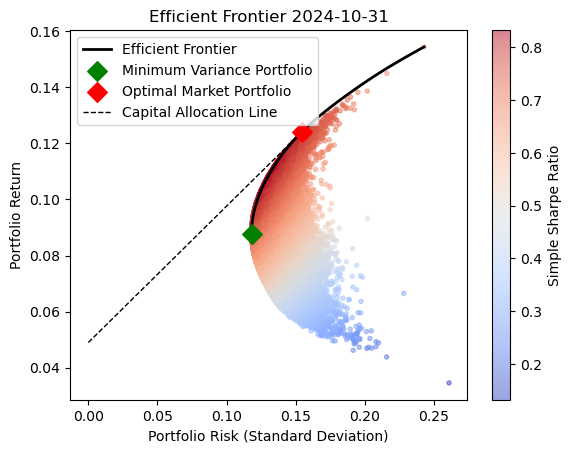

In [57]:
start_date = datetime(2024, 10, 31)
end_date = datetime(2024, 10, 31)
min_var_weights_df = pd.DataFrame(columns=least_correlated_stocks)
optimal_weights_df = pd.DataFrame(columns=least_correlated_stocks)

while start_date <= end_date:
    sample_start = start_date - relativedelta(years=5)
    sample_start = sample_start.replace(day=1)
    portfolio_calculations(sample_start.strftime('%Y-%m-%d'), start_date.strftime('%Y-%m-%d'), min_var_weights_df, optimal_weights_df)
    start_date += relativedelta(months=6)
    

In [48]:
min_var_weights_df

,ASTRAZENECA,SAGE GROUP,BAE SYSTEMS,BUNZL,RIO TINTO
2024-10-31,0.303599,0.164116,0.203003,0.156165,0.173118


In [8]:
optimal_weights_df

,ASTRAZENECA,SAGE GROUP,BAE SYSTEMS,BUNZL,RIO TINTO
2014-10-31,0.229834,0.000000,0.000000,0.770166,0.000000
2015-04-30,0.135104,0.081675,0.000000,0.783221,0.000000
2015-10-30,0.000000,0.063006,0.000000,0.936994,0.000000
2016-04-30,0.001174,0.121921,0.002887,0.874018,0.000000
2016-10-30,0.003976,0.247552,0.094436,0.654036,0.000000
2017-04-30,0.000000,0.142372,0.293854,0.563774,0.000000
2017-10-30,0.000000,0.285189,0.307863,0.353349,0.053599
2018-04-30,0.006732,0.336832,0.239853,0.355559,0.061024
2018-10-30,0.153988,0.181983,0.100914,0.499617,0.063497
2019-04-30,0.106910,0.446013,0.000000,0.301908,0.145170
